Based on https://bambinos.github.io/bambi/main/notebooks/multi-level_regression.html

# Hierarchical Linear Regression (Pigs dataset)

In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xarray as xr

az.style.use("arviz-darkgrid")
SEED = 7355608

In [2]:
# Load up data from statsmodels
data = sm.datasets.get_rdataset("dietox", "geepack").data
data.describe()

,Pig,Litter,Start,Weight,Feed,Time
count,861.000000,861.000000,861.000000,861.000000,789.000000,861.000000
mean,6238.319396,12.135889,25.672701,60.725769,80.728645,6.480836
std,1323.845928,7.427252,3.624336,24.978881,52.877736,3.444735
min,4601.000000,1.000000,15.000000,15.000000,3.300003,1.000000
25%,4857.000000,5.000000,23.799990,38.299990,32.800003,3.000000
50%,5866.000000,11.000000,25.700000,59.199980,74.499996,6.000000
75%,8050.000000,20.000000,27.299990,81.199950,123.000000,9.000000
max,8442.000000,24.000000,35.399990,117.000000,224.500000,12.000000


In [3]:
model = bmb.Model("Weight ~ Time + (Time|Pig)", data)
results = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Time, 1|Pig_sigma, 1|Pig_offset, Time|Pig_sigma, Time|Pig_offset, Weight_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [4]:
model

Formula: Weight ~ Time + (Time|Pig)
Family name: Gaussian
Link: identity
Observations: 861
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 60.7258, sigma: 133.0346)
    Time ~ Normal(mu: 0.0, sigma: 18.1283)

  Group-level effects
    1|Pig ~ Normal(mu: 0, sigma: HalfNormal(sigma: 133.0346))
    Time|Pig ~ Normal(mu: 0, sigma: HalfNormal(sigma: 18.1283))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 24.9644)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

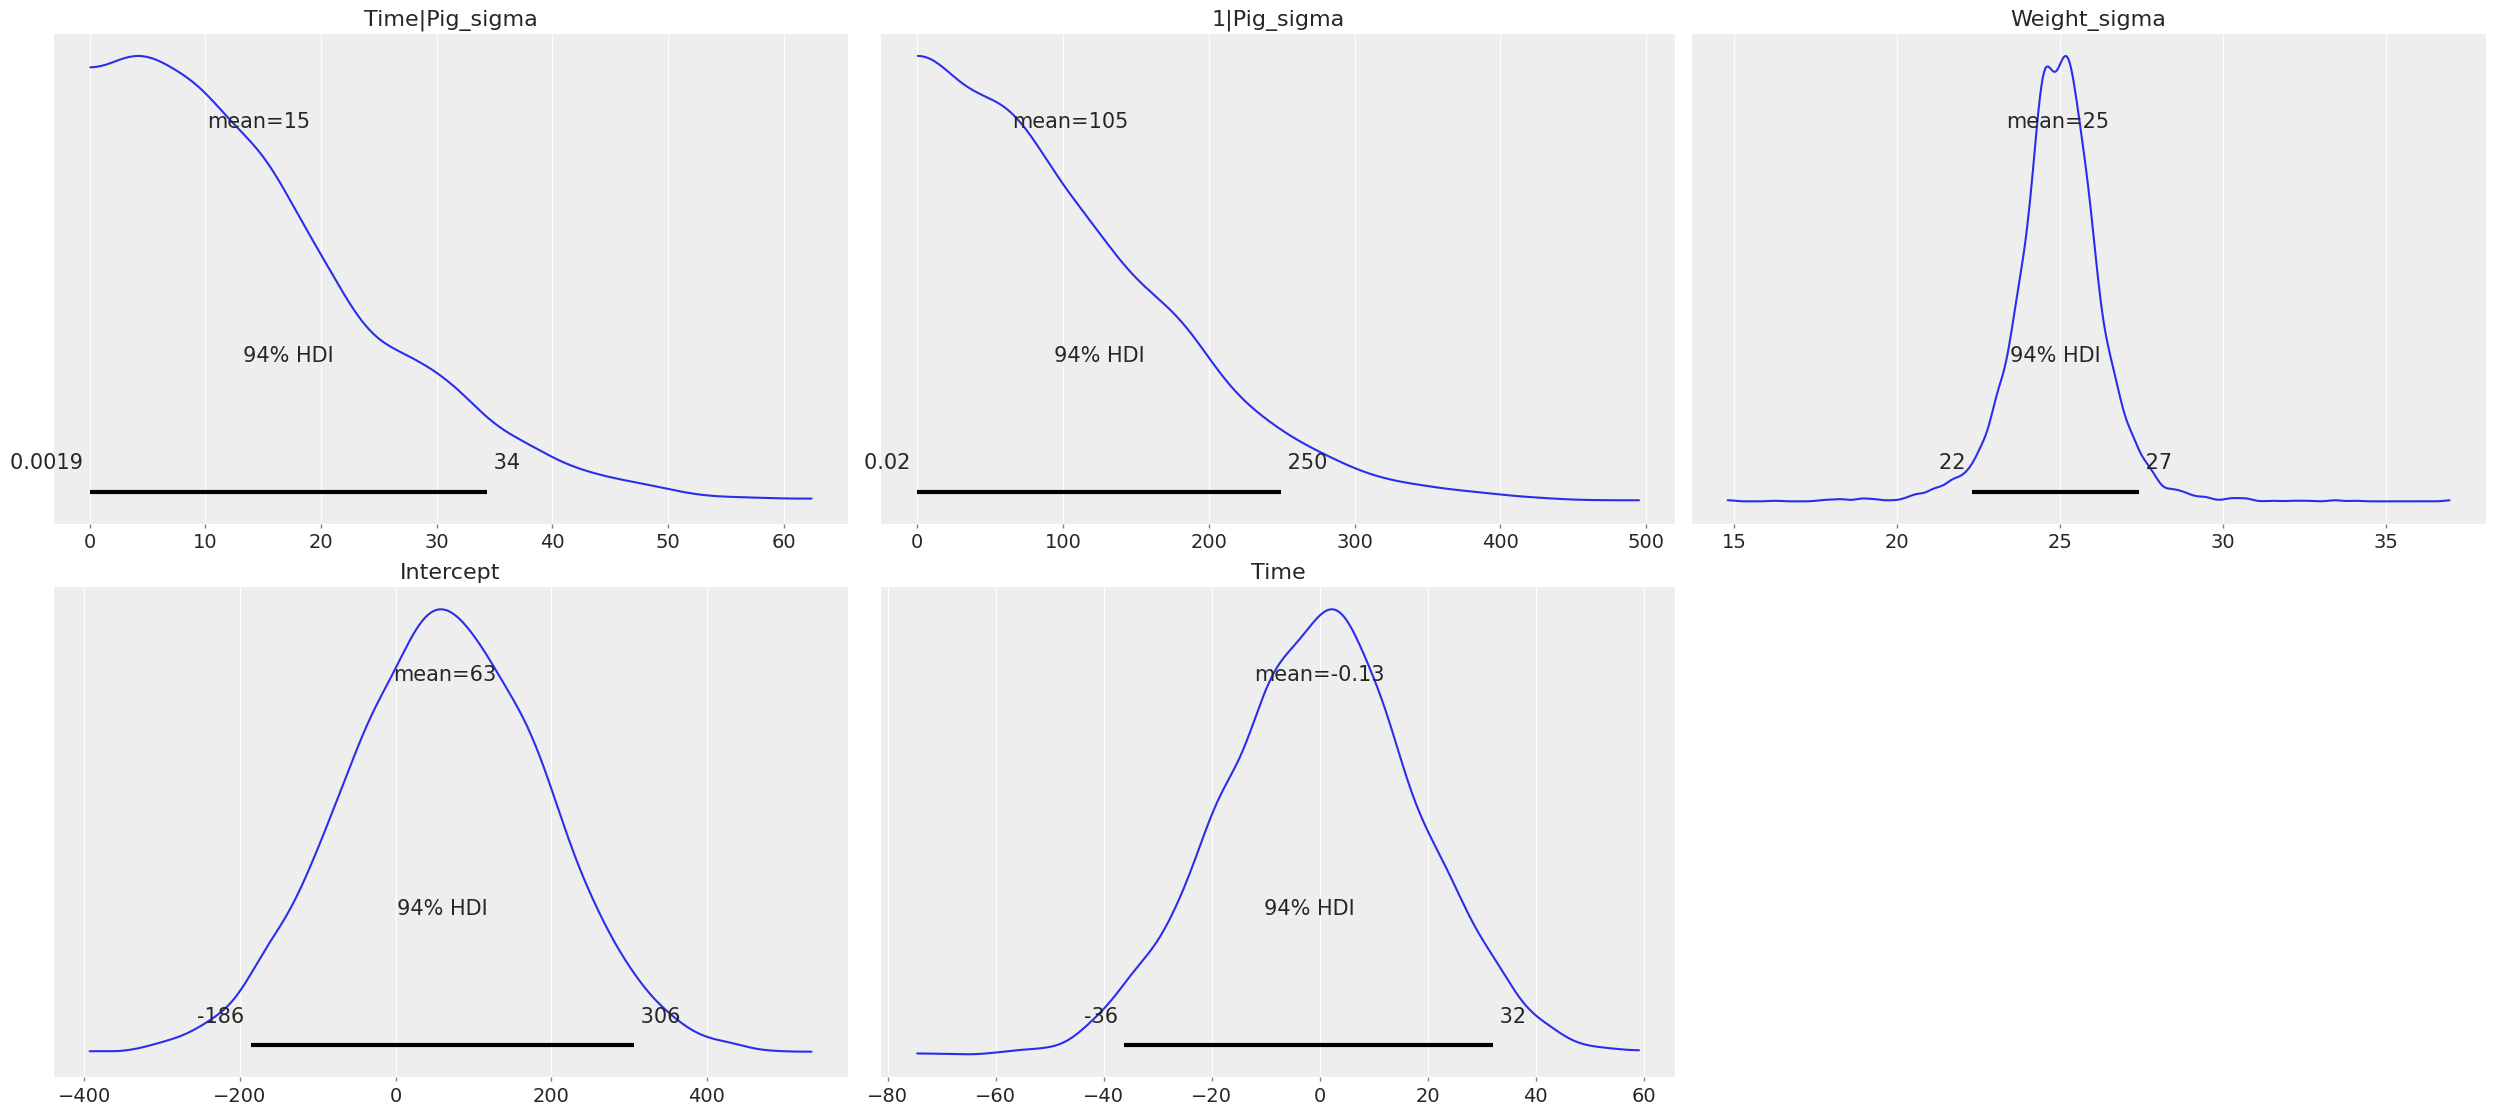

In [5]:
model.plot_priors();

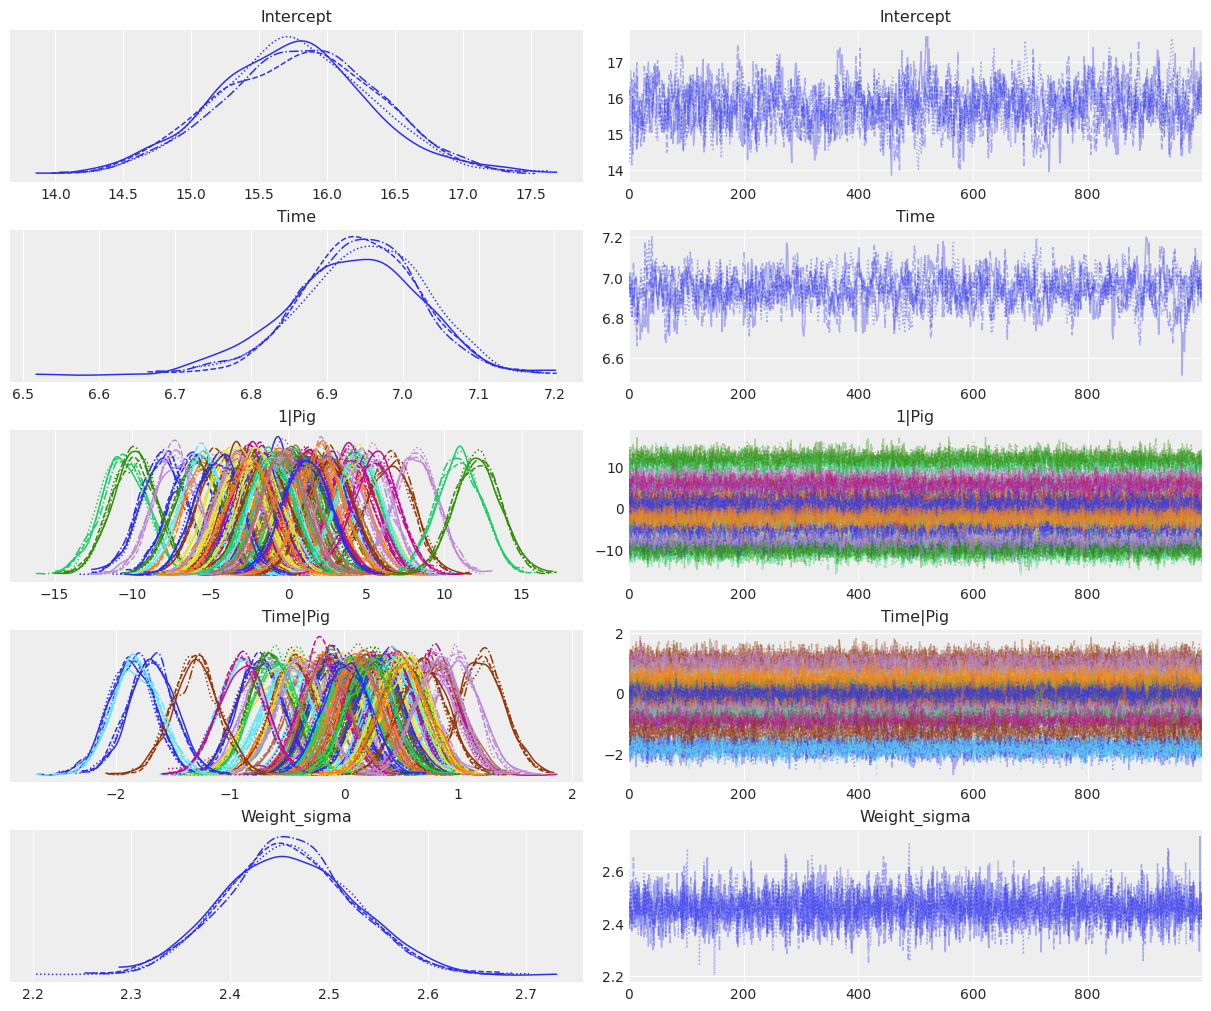

In [6]:
# Plot posteriors
az.plot_trace(
    results,
    var_names=["Intercept", "Time", "1|Pig", "Time|Pig", "Weight_sigma"],
    compact=True,
);

In [7]:
az.summary(results, var_names=["Intercept", "Time", "1|Pig_sigma", "Time|Pig_sigma", "Weight_sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,15.773,0.578,14.646,16.823,0.021,0.015,787.0,1232.0,1.00
Time,6.942,0.082,6.793,7.099,0.003,0.002,669.0,909.0,1.01
1|Pig_sigma,4.546,0.423,3.790,5.379,0.011,0.008,1379.0,2031.0,1.00
Time|Pig_sigma,0.662,0.062,0.550,0.778,0.002,0.001,1139.0,1991.0,1.00
Weight_sigma,2.460,0.065,2.340,2.580,0.001,0.001,5630.0,3379.0,1.00


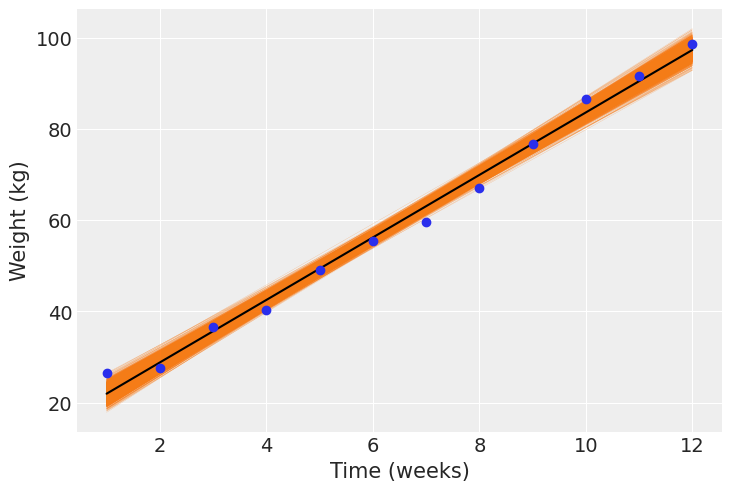

In [8]:
# The ID of the first pig is '4601'
data_0 = data[data["Pig"] == 4601][["Time", "Weight"]]
time = np.array([1, 12])

posterior = az.extract_dataset(results)
intercept_common = posterior["Intercept"]
slope_common = posterior["Time"]

intercept_specific_0 = posterior["1|Pig"].sel(Pig__factor_dim="4601")
slope_specific_0 = posterior["Time|Pig"].sel(Pig__factor_dim="4601")

a = (intercept_common + intercept_specific_0)
b = (slope_common + slope_specific_0)

# make time a DataArray so we can get automatic broadcasting
time_xi = xr.DataArray(time)
plt.plot(time_xi, (a + b * time_xi).T, color="C1", lw=0.1)
plt.plot(time_xi, a.mean() + b.mean() * time_xi, color="black")
plt.scatter(data_0["Time"], data_0["Weight"], zorder=2)
plt.ylabel("Weight (kg)")
plt.xlabel("Time (weeks)");

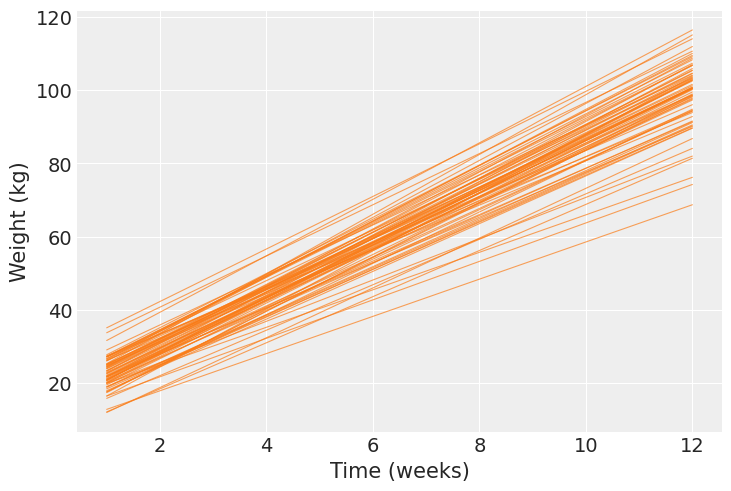

In [9]:
intercept_group_specific = posterior["1|Pig"]
slope_group_specific = posterior["Time|Pig"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean() + slope_group_specific.mean("sample")
time_xi = xr.DataArray(time)
plt.plot(time_xi, (a + b * time_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("Weight (kg)")
plt.xlabel("Time (weeks)");

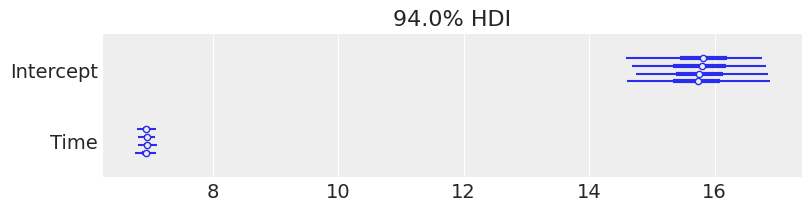

In [10]:
az.plot_forest(
    results,
    var_names=["Intercept", "Time"],
    figsize=(8, 2),
);

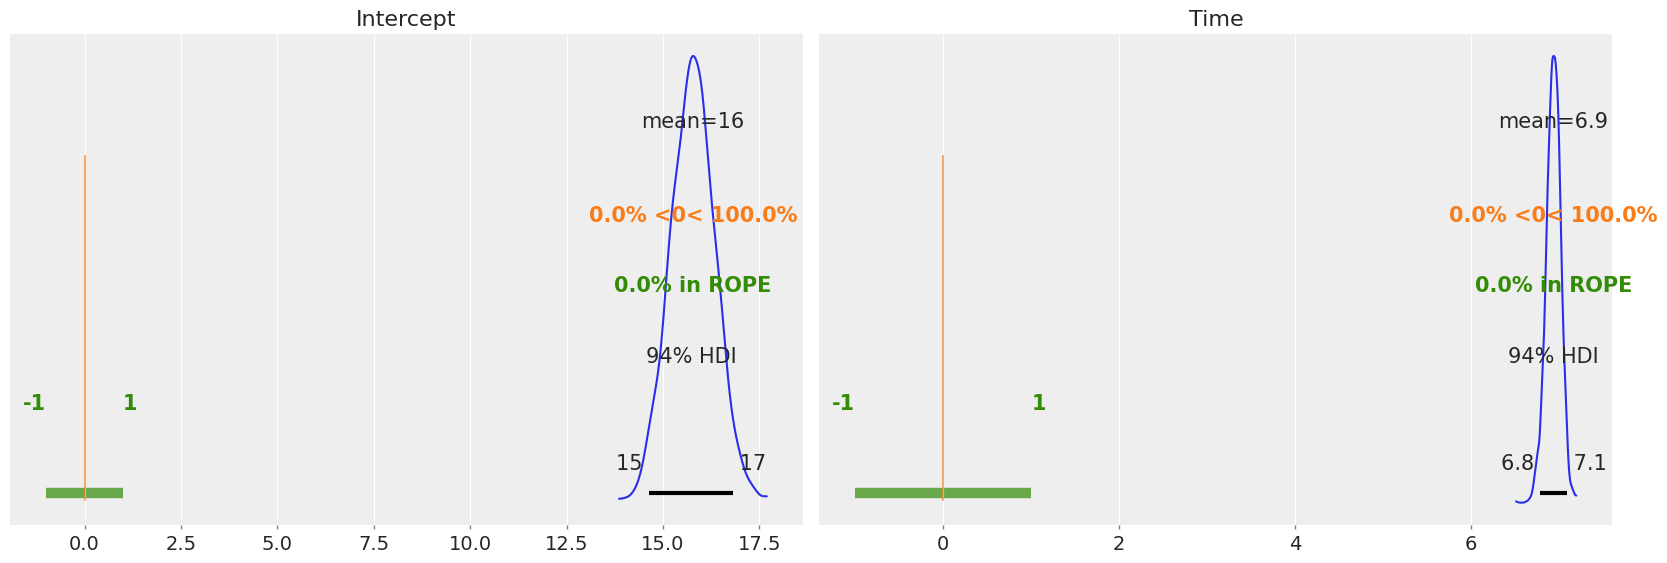

In [11]:
az.plot_posterior(results, var_names=["Intercept", "Time"], ref_val=0, rope=[-1, 1]);

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Aug 19 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

bambi      : 0.9.0
statsmodels: 0.13.2
arviz      : 0.12.1
xarray     : 2022.6.0
numpy      : 1.21.6
matplotlib : 3.5.3

Watermark: 2.3.1

